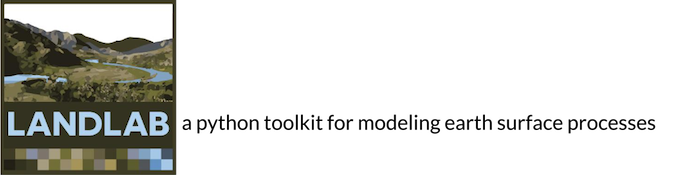

# Practical 1: Hydrology

## What is this notebook?

This notebook illustrates the importance of rainfall intensity and duration on the characteristics of hydrographs, along with the role of infiltration. Remember that hydrographs are one of the main ways we can assess fluvial flooding and then think about catchment management.

We will use free, open-source modelling software called [LandLab](http://landlab.github.io/) to simulate overland flow and infiltration. Note we are not simulating the existing flow in the river; just the run-off.

For those that went on the rivers field trip we discussed why run-off is important in Forge Valley, so here we're going to use Forge Valley to test some of the ideas we discussed on the trip and the recorded lectures. For those that went to the coast, the recorded lectures contain everything you need to know, but feel free to chat to someone who did go to Forge Valley for why run-off is partcilarly importnat here.

## What the model simulates

The model is a simplified shallow water equation solver that models water flowing downhill. The base equaiton solved is:

\begin{equation}
\frac{\partial H}{\partial t} = (P - I) - \nabla\cdot\mathbf{q}
\end{equation}

What this equation says is that the water depth, $H$, changes through time, $t$, by the precipitation rate, $P$, infiltration rate, $I$ and the water discharge, $\mathbf{q}$, comining in and out of each grid cell. The upsidedown triangle, $\nabla$ means take the gradient in space $(x,y)$. $\mathbf{q}$ is calculated using:

\begin{equation}
\mathbf{q} = \frac{H^{4/3}}{n^2 U_c} \nabla w
\end{equation}

Where $n$ is the Manning's drag coefficient, $U_c$ is a velocity scale (here 1 m/s) and $w$ is the water surface elevation (height of the land + $H$). Finally, $I$ is calculated using:

\begin{equation}
I = I_c \left( 1 - e^{-H / H_i} ) \right)
\end{equation}

so that we only infiltrate water when there is some surface water and these smoothly trends to 0 infiltration when there is no water on the surface. $H_i$ is a characteristic water depth (here 0.1 mm) to make sure the model is stable with very small amounts of water.

## What we are going to do

We are going to simulate the central section of Forge Valley in the North York Moors and see what happens during a brief, intense storm. We will then alter the infiltration rate, drag coefficient and storm intensity and duration to see how the run-off hydrology is affected by the environment.

No infiltration is like having hard surfaces (tarmac) or baked soil (e.g. after a wildfire). Low infiltration acts like the soil is already getting to capacity. Manning's drag alters the land surface characteristics.

The practical is in two parts. The first runs the base model with no infiltration. The second allows you to edit parameters and re-run, comparing to the original model. It's worth creating a google docs or similar to copy and paste images and make notes.

Start at the top by reading each block of text and sequentially running each code block (click the little "play" symbol on the left of a block of code).

If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. For example, if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.

**What to do..**

Run each block of code once until you get to the text that says **stop here**. Then stop, and read the instrucitons carefullly! Make sure there are no errors. Ask for help if things don't work.





In [ ]:
# this code install landlab and necessary things. You only need to do this once.
!pip install landlab
!git clone https://github.com/jhill1/hydrological_coastal_processes.git

From this point each block of code is numbered using the comment: `# Code Block 1` or similar. The `#` symbol is a comment, so is not run in the code. Some comments will also tell you what the code is doing, if you're interested. The instructions below refer to these `Code Block` numbers.

In [ ]:
# Code Block 1
from landlab import RasterModelGrid, imshow_grid
from landlab.components.overland_flow import LinearDiffusionOverlandFlowRouter
from landlab.io import read_esri_ascii
import numpy as np
from matplotlib import pyplot as plt

#below is to make plots show up in the notebook
%matplotlib inline

In [ ]:
# Code Block 3

(demgrid, demelev) = read_esri_ascii(
    "/content/hydrological_coastal_processes/prac_1/FV_10m_DEM_filled_sml.asc",
    name="topographic__elevation"
)
# Create Landlab model grid and assign the DEM elevations to it,
# then display the terrain.
# (note: DEM horizontal and vertical units are meters)
grid = RasterModelGrid(
    (demgrid.number_of_node_rows, demgrid.number_of_node_columns), xy_spacing=demgrid.dx
)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = demelev
imshow_grid(grid, elev, colorbar_label="Elevation (m)")
scaling = 3600*1000

In [ ]:
# Code Block 4

# Process parameters
n = 0.025  # roughness coefficient, (s/m^(1/3))
uc = 1.0  # characteristic velocity scale (m/s)
R1 = 72.0 # Initial rainfall (storm event) mm/hr
R2 = 0.0  # Rainfall after event mm/hr
infilt_cap = 0  # infiltration capacity, mm/hr

# scale parameters to m/s
R1 = R1 / scaling
R2 = R2 / scaling
infilt_cap = infilt_cap / scaling

# Run-control parameters
heavy_rain_duration = 300.0  # duration of heavy rainfall, s
run_time = 3600.0  # duration of run, s
dt = 10.0  # time-step size, s

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge, time, and rain rate
time_since_storm_start = np.linspace(0.0, run_time, num_steps + 1)
discharge = np.zeros(num_steps + 1)
rain_rate = np.zeros(num_steps + 1)
rain_rate[:] = R1
rain_rate[time_since_storm_start >= heavy_rain_duration] = R2

# plot the rainfall
plt.plot(time_since_storm_start / 60.0, rain_rate * scaling)
plt.xlabel("Time (min)")
plt.ylabel("Rainfall (mm/hr)")
plt.grid(True)

params_message = "R1: {r1}, R2: {r2}, Infiltration: {ic}, n: {n}".format(r1=R1*scaling, r2=R2*scaling, ic=infilt_cap*scaling, n=n)

In [ ]:
# Code Block 5

# Configure the boundaries: valid bottom-edge nodes will be open;
grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_FIXED_VALUE
grid.status_at_node[np.isclose(elev, -9999.0)] = grid.BC_NODE_IS_CLOSED
indices = np.where(elev[grid.nodes_at_bottom_edge] > 0.0)[0]
outlet_nodes = grid.nodes_at_bottom_edge[indices]
links_at_outlets = grid.links_at_node[outlet_nodes]
links_to_track = links_at_outlets[
    grid.status_at_link[links_at_outlets] == grid.BC_LINK_IS_ACTIVE
].flatten()

In [ ]:
# Code Block 6

# Instantiate the component
olflow = LinearDiffusionOverlandFlowRouter(
    grid, rain_rate=R1, infilt_rate=infilt_cap, roughness=n, velocity_scale=1.0, cfl_factor = 0.75
)


In [ ]:
# Code Block 7

# clear everything and start running the simulation.
q = grid.at_link["water__specific_discharge"]
grid.at_node["surface_water__depth"][:] =  0.0
water_after_storm = grid.at_node["surface_water__depth"]

for i in range(num_steps):
    t = i * dt
    print("Time: ", t)
    olflow.rain_rate = rain_rate[i]
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(np.abs(q[links_to_track])) * grid.dx
    if (t < heavy_rain_duration):
      water_after_storm =  np.copy(grid.at_node['surface_water__depth'])

In [ ]:
# Code Block 8

plt.plot(time_since_storm_start / 60.0, discharge)
plt.title("Discharge: "+params_message)
plt.xlabel("Time (min)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

In [ ]:
# Code Block 9

fig = plt.figure()
fig.tight_layout()
fig.suptitle('Surface water depth: '+ params_message)
fig.add_subplot(131)
imshow_grid(grid, water_after_storm, plot_name="At end of storm", cmap='Blues', vmax=0.75)
fig.add_subplot(132)
imshow_grid(grid, grid.at_node['surface_water__depth'], plot_name="At end of simulation", cmap='Blues', vmax=0.75)
fig.add_subplot(133)
plt.subplots_adjust(right=1.75)
imshow_grid(grid, grid.at_node['surface_water__depth']-water_after_storm, plot_name="Difference", cmap='seismic', symmetric_cbar=True)



In [ ]:
# Code Block 10

# store everything for comparison later
water_after_storm_orig = water_after_storm
water_after_hour = np.copy(grid.at_node['surface_water__depth'])
discharge_orig = discharge

**STOP HERE**

At this point you have a simulation that takes the basic DEM (topographic data) and simulates a heavy rainfall for 300 seconds (5 minutes) and then no rain to the end of the simulation (1 hour).

The simulation siomulates the flow of water overland, but we haven't added an infiltration into the soil (i.e. the land is completely impermeable). We also have a very low drag coefficient (equivalent to "clean sand" everywhere). For those on the rivers field trip a few weeks ago, does this sound realsitic?

Have a think about these questions and write down some answers:

1. Will the amount of surface water and discharge increase or decrease when infiltration rate is added to the model?
2. If the drag coefficient (Manning's) is increased, will that increase the discharge? How does increasing the drag coefficient interact with increased infilatration rate?
3. Does the intensity (amount and duration) of the rain matter?


Now edit some of the parameters (one at a time to start with!). Things to try are:
* mannings, `n`, (Original value: 0.025. Try 0.1 and 0.01)
* infiltration rate, `infilt_cap` (Original value: 0. Try 10 and 30 mm/hr)
* storm intensity, `R1` (Original value: 72 mm/hr. Try 10 and 30 mm/hr)
* add rain after storm, `R2`, (Original value: 0 mm/hr. Try  5 mm/hr)

You don't have to try all combinations! Some ideas are above. For each, copy and paste the figures into a google doc and then use that saem doc to answer the questions below. I'll distribute answers via the VLE later.

**NOTE:** For the rest of the questions you should use Code Blocks 11-14. These will allow you to use compare the results from the original run.

For each part below, run code blocks 11-14 after editing the relevant parameters to answer the questions above.

**Final Reflection**. Was your initial insight into how parameters would affect the landscape correct?

How do we change the drag coefficient and infiltration rate in reality? How does this effect management of catchments?

In [ ]:
# Code Block 11

# Process parameters. These are what you can edit
###################################################

n = 0.025  # roughness coefficient, (s/m^(1/3))
R1 = 72.0 # Initial rainfall (storm event) mm/hr
R2 = 0.0  # Rainfall after event mm/hr
infilt_cap = 10  # infiltration capacity, mm/hr

####### DONT EDIT THESE################
# scale parameters to m/s
uc = 1.0  # characteristic velocity scale (m/s)
R1 = R1 / scaling
R2 = R2 / scaling
infilt_cap = infilt_cap / scaling

# Run-control parameters
heavy_rain_duration = 300.0  # duration of heavy rainfall, s
run_time = 3600.0  # duration of run, s
dt = 10.0  # time-step size, s

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge, time, and rain rate
time_since_storm_start = np.linspace(0.0, run_time, num_steps + 1)
discharge = np.zeros(num_steps + 1)
rain_rate = np.zeros(num_steps + 1)
rain_rate[:] = R1
rain_rate[time_since_storm_start >= heavy_rain_duration] = R2

# plot the rainfall
plt.plot(time_since_storm_start / 60.0, rain_rate * scaling)
plt.xlabel("Time (min)")
plt.ylabel("Rainfall (mm/hr)")
plt.grid(True)

params_message = "R1: {r1}, R2: {r2}, Infiltration: {ic}, n: {n}".format(r1=R1*scaling, r2=R2*scaling, ic=infilt_cap*scaling, n=n)

# Instantiate the component
olflow = LinearDiffusionOverlandFlowRouter(
    grid, rain_rate=R1, infilt_rate=infilt_cap, roughness=n, velocity_scale=1.0, cfl_factor = 0.75
)


In [ ]:
# Code Block 12

# run sim block
q = grid.at_link["water__specific_discharge"]
grid.at_node["surface_water__depth"][:] =  0.0
water_after_storm = grid.at_node["surface_water__depth"]

for i in range(num_steps):
    t = i * dt
    print("Time: ", t)
    olflow.rain_rate = rain_rate[i]
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(np.abs(q[links_to_track])) * grid.dx
    if (t < heavy_rain_duration):
      water_after_storm =  np.copy(grid.at_node['surface_water__depth'])

In [ ]:
# Code Block 13

# produce hydrograph plots (diff lines)
plt.plot(time_since_storm_start / 60.0, discharge, label="This run")
plt.plot(time_since_storm_start / 60.0, discharge_orig, label="Orig run")
plt.title("Discharge: "+params_message)
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

In [ ]:
# Code Block 14

# Produce water depth plot (2x2; orig on top, new on bottom)
fig = plt.figure()
fig.tight_layout()
fig.suptitle('Surface water depth: '+ params_message)
fig.add_subplot(131)
imshow_grid(grid, water_after_storm, plot_name="At end of storm", cmap='Blues', vmax=0.75)
fig.add_subplot(132)
imshow_grid(grid, grid.at_node['surface_water__depth'], plot_name="At end of simulation", cmap='Blues', vmax=0.75)
fig.add_subplot(133)
plt.subplots_adjust(right=1.75)
imshow_grid(grid, grid.at_node['surface_water__depth']-water_after_storm, plot_name="Difference", cmap='seismic', symmetric_cbar=True)
